# SynthMorph Affine PyTorch Demo
## Purpose
Reproduce the original affine components of SynthMorph demo in Torch.
- Data generation with affine augmentations
- Affine registration model training
- Registration (inference) examples  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import urllib
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np 
import torch
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import pytorch_lightning as pl

# local code
from synthmorph import networks, models, layers, losses, datamodule as dm, utils

In [3]:
with torch.no_grad():
    torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # note: only gpu has been tested so far
torch.set_default_device(device)
# mp.set_start_method('spawn')

## SynthMorph Affine Generation

### Generate Label (i.e. Segmentation) Map

In [4]:
in_shape = (256,) * 2
num_labels = 16

100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


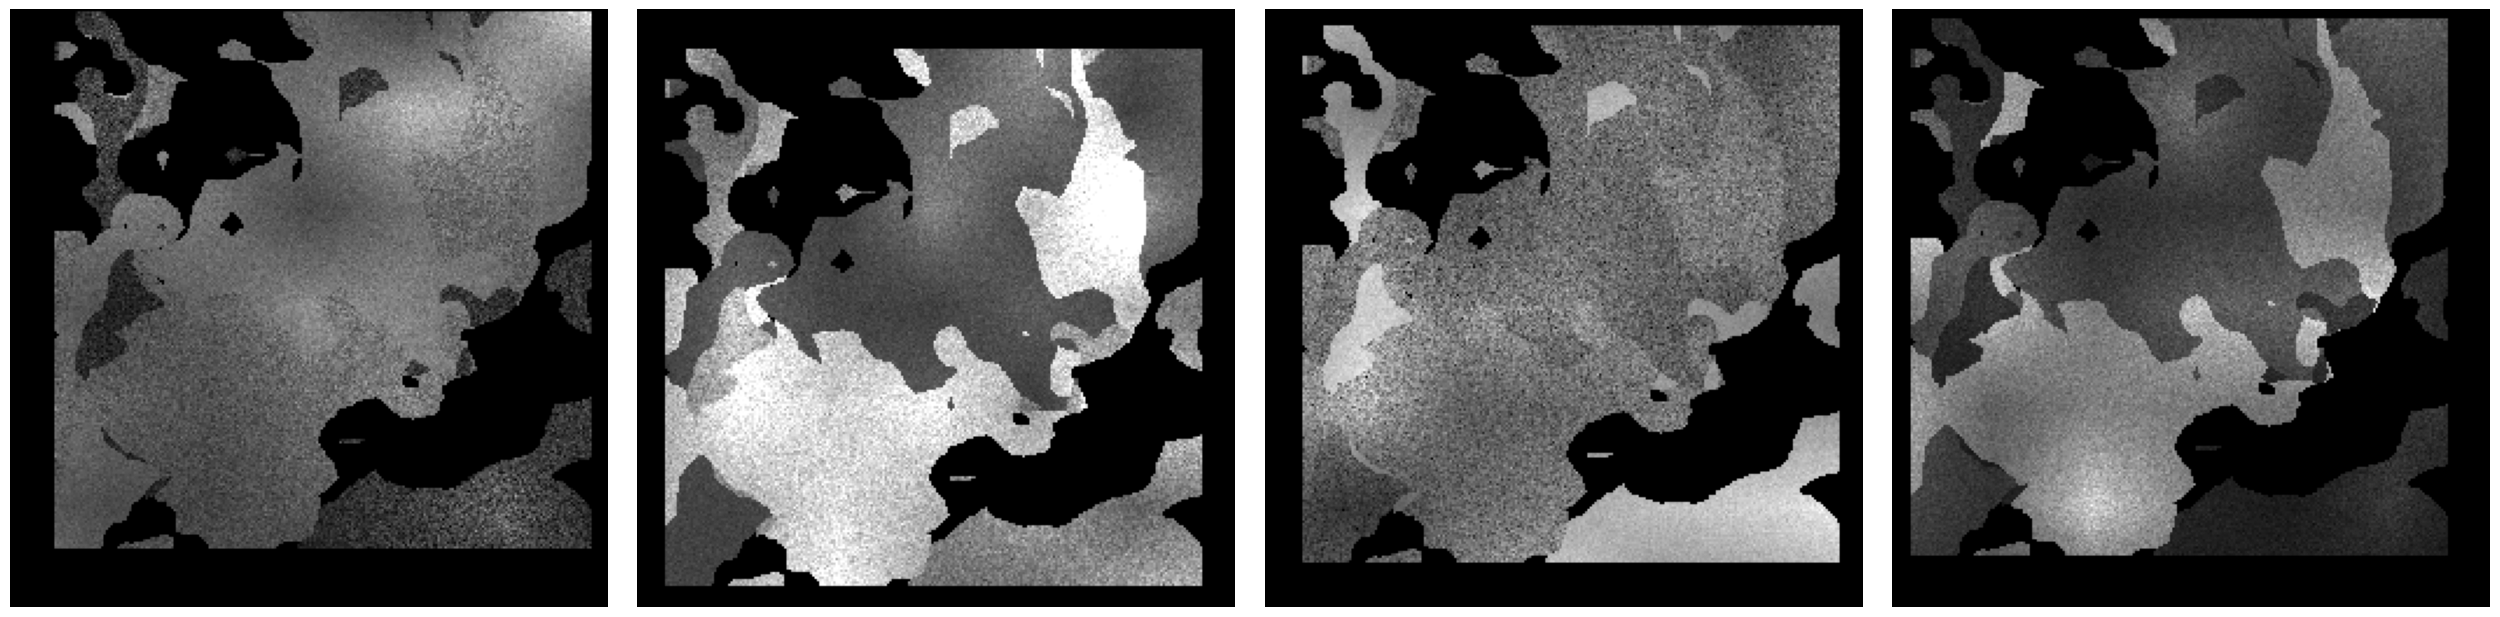

In [5]:
# Input shapes.
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 4
label_map = dm.generate_map(in_shape, num_label, device=device)
n = 4
affine_args = dict(
    translate=(0.05, 0.05),
    scale=(0.9, 0.9)
)
gen_args = dict(
    warp_std=0,
    warp_res=(8, 16, 32),
    zero_background=1,
    affine_args=affine_args,
)

gen = [dm.labels_to_image(label_map, **gen_args) for _ in tqdm(range(n))]
gen_images = [g['image'] for g in gen]
gen_labels= [g['label'] for g in gen]

plot_num = min(n, 4)
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*8, 8))

for i in range(plot_num):
    image = gen_images[i].squeeze().tolist()
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.05)
plt.show()

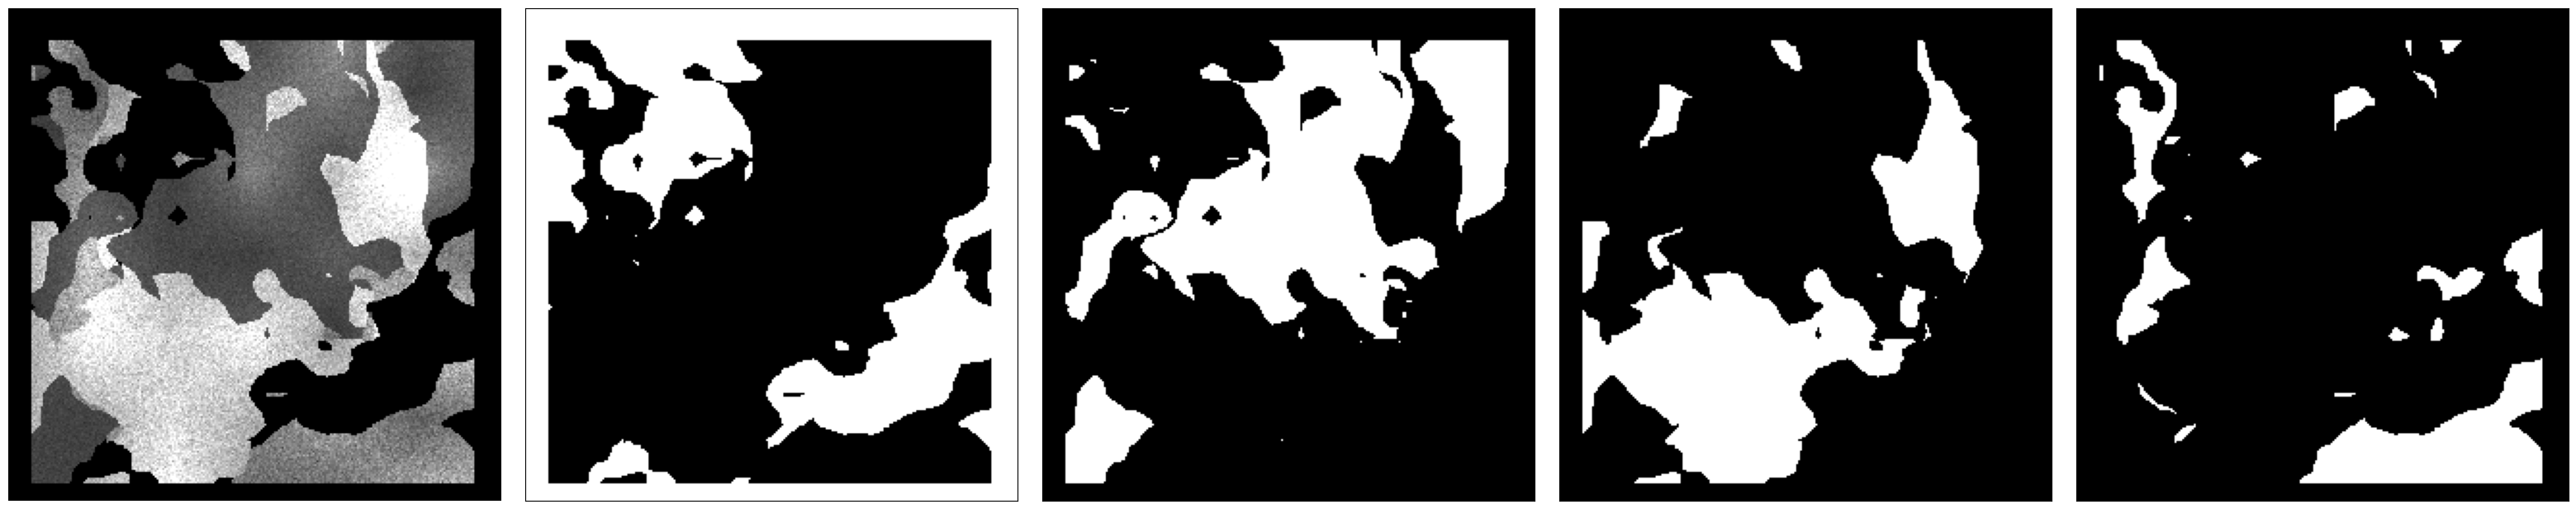

In [6]:
# Plot each label of an image
ind = 1
image = gen_images[ind].squeeze().tolist()
labels = gen_labels[ind].squeeze().tolist()
plot_num = gen_labels[ind].shape[0] + 1
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*8, 8))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
for c in range(1, plot_num):
    ax = axes[c]
    l = labels[c - 1]
    ax.imshow(l, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

## Affine Model Training

In [7]:
# Training data generator
size=40
in_shape = (256,) * 2
num_labels = 16
affine_args = dict(
    translate=(0.05, 0.05),
    scale=(0.9, 0.9)
)
gen_args = dict(
    warp_std=0, # no deformable transformation
    warp_res=(8, 16, 32),
    zero_background=1,
    affine_args=affine_args,
)

train_data = dm.SMShapesDataset(
    size=size,
    input_size=in_shape,
    num_labels=num_labels,
    gen_args=gen_args,
)
dataloader_kwargs = {'num_workers': 8, 'persistent_workers': True,} if device == 'cuda' else {}
dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    shuffle=True,
    **dataloader_kwargs
)

100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


In [14]:
reg_model = networks.VxmAffineFeatureDetector(
    in_shape=in_shape
)
# model = SynthMorphAffine(

# )
n_param = utils.torch_model_parameters(reg_model)

+-----------------------------+-----------+
|            Module           | Parameter |
+-----------------------------+-----------+
| det.encoder.0.0.main.weight |    4608   |
|  det.encoder.0.0.main.bias  |    256    |
| det.encoder.1.0.main.weight |   589824  |
|  det.encoder.1.0.main.bias  |    256    |
| det.encoder.2.0.main.weight |   589824  |
|  det.encoder.2.0.main.bias  |    256    |
| det.encoder.3.0.main.weight |   589824  |
|  det.encoder.3.0.main.bias  |    256    |
| det.remaining.0.main.weight |   589824  |
|  det.remaining.0.main.bias  |    256    |
| det.remaining.1.main.weight |   589824  |
|  det.remaining.1.main.bias  |    256    |
| det.remaining.2.main.weight |   589824  |
|  det.remaining.2.main.bias  |    256    |
| det.remaining.3.main.weight |   589824  |
|  det.remaining.3.main.bias  |    256    |
|         out.0.weight        |   147456  |
|          out.0.bias         |     64    |
+-----------------------------+-----------+
Total Trainable Params: 4282944
